In [1]:
# Install Dependencies
!apt update && apt install -y poppler-utils
!pip install --upgrade pdf2image PyMuPDF Pillow

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:5 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,772 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [5,094 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Pac

In [2]:
# Importing all the dependencies
import fitz  # PyMuPDF
import re
from PIL import Image, ImageDraw
from google.colab import files
from IPython.display import display
from pprint import pprint

In [3]:
# Upload the invoice PDF
uploaded = files.upload()
file_path = list(uploaded.keys())[0]

Saving sample_invoice.pdf to sample_invoice.pdf


In [4]:
# Load PDF
doc = fitz.open(file_path)
page = doc[0]
text = page.get_text()
words = page.get_text("words")  # each word: [x0, y0, x1, y1, text, block_no, line_no, word_no]

In [5]:
# Extract Fields
data = {}

In [6]:
# Extract Invoice Number & Date (full match)
invoice_number_match = re.search(r"Invoice Number:\s*(\S+)", text)
date_match = re.search(r"Date:\s*([A-Za-z]+\s\d{1,2},\s\d{4})", text)

data["Invoice Number"] = invoice_number_match.group(1) if invoice_number_match else None
data["Date"] = date_match.group(1) if date_match else None

In [7]:
# Extract Line Items
line_item_pattern = re.compile(
    r"(?P<description>[^\n]+?)\s+(?P<qty>\d+)\s+(?P<unit_price>[\d,]+\.\d{2})\s+(?P<total>[\d,]+\.\d{2})"
)

line_items = []
for match in line_item_pattern.finditer(text):
    item = {
        "description": match.group("description").strip(),
        "quantity": match.group("qty"),
        "unit_price": match.group("unit_price"),
        "total": match.group("total")
    }
    line_items.append(item)

data["Line Items"] = line_items

print("Extracted Invoice Data:")
pprint(data)

Extracted Invoice Data:
{'Date': 'July 30, 2025',
 'Invoice Number': 'INV-2025-07-001',
 'Line Items': [{'description': 'Laptop - Model X200',
                 'quantity': '2',
                 'total': '130,000.00',
                 'unit_price': '65,000.00'},
                {'description': 'External Hard Drive 1TB',
                 'quantity': '5',
                 'total': '22,500.00',
                 'unit_price': '4,500.00'},
                {'description': 'Wireless Keyboard & Mouse',
                 'quantity': '3',
                 'total': '3,600.00',
                 'unit_price': '1,200.00'},
                {'description': 'Software License (Annual)',
                 'quantity': '1',
                 'total': '15,000.00',
                 'unit_price': '15,000.00'}]}


In [8]:
# Find and Highlight Matching Words ----------
highlight_boxes = []

def normalize(s):
    return s.strip().replace(",", "").lower()

def find_boxes_for_text(text_fragment):
    boxes = []
    words_in_fragment = text_fragment.split()
    norm_words = [normalize(w) for w in words_in_fragment]

    for w in words:
        word_clean = normalize(w[4])
        if word_clean in norm_words:
            boxes.append((w[:4], w[4]))
    return boxes

In [9]:
# Highlight Invoice Number
if data["Invoice Number"]:
    box = find_boxes_for_text(data["Invoice Number"])
    highlight_boxes.extend([(b, "Invoice Number") for b, _ in box])

In [10]:
# Highlight Date (multi-word)
if data["Date"]:
    date_words = find_boxes_for_text(data["Date"])
    for b, word in date_words:
        highlight_boxes.append((b, "Date"))


In [11]:
# Highlight Line Items: description, quantity, unit_price, total
for idx, item in enumerate(data["Line Items"]):
    for field_key in ["description", "quantity", "unit_price", "total"]:
        label = f"Item {idx+1}: {field_key}"
        boxes = find_boxes_for_text(str(item[field_key]))
        highlight_boxes.extend([(b, label) for b, _ in boxes])


In [12]:
# Draw Red Boxes ----------
zoom = 2
mat = fitz.Matrix(zoom, zoom)
pix = page.get_pixmap(matrix=mat)
img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

draw = ImageDraw.Draw(img)
for (x0, y0, x1, y1), label in highlight_boxes:
    x0, y0, x1, y1 = [int(c * zoom) for c in (x0, y0, x1, y1)]
    draw.rectangle([x0, y0, x1, y1], outline="red", width=2)
    draw.text((x0, y0 - 12), label, fill="red")

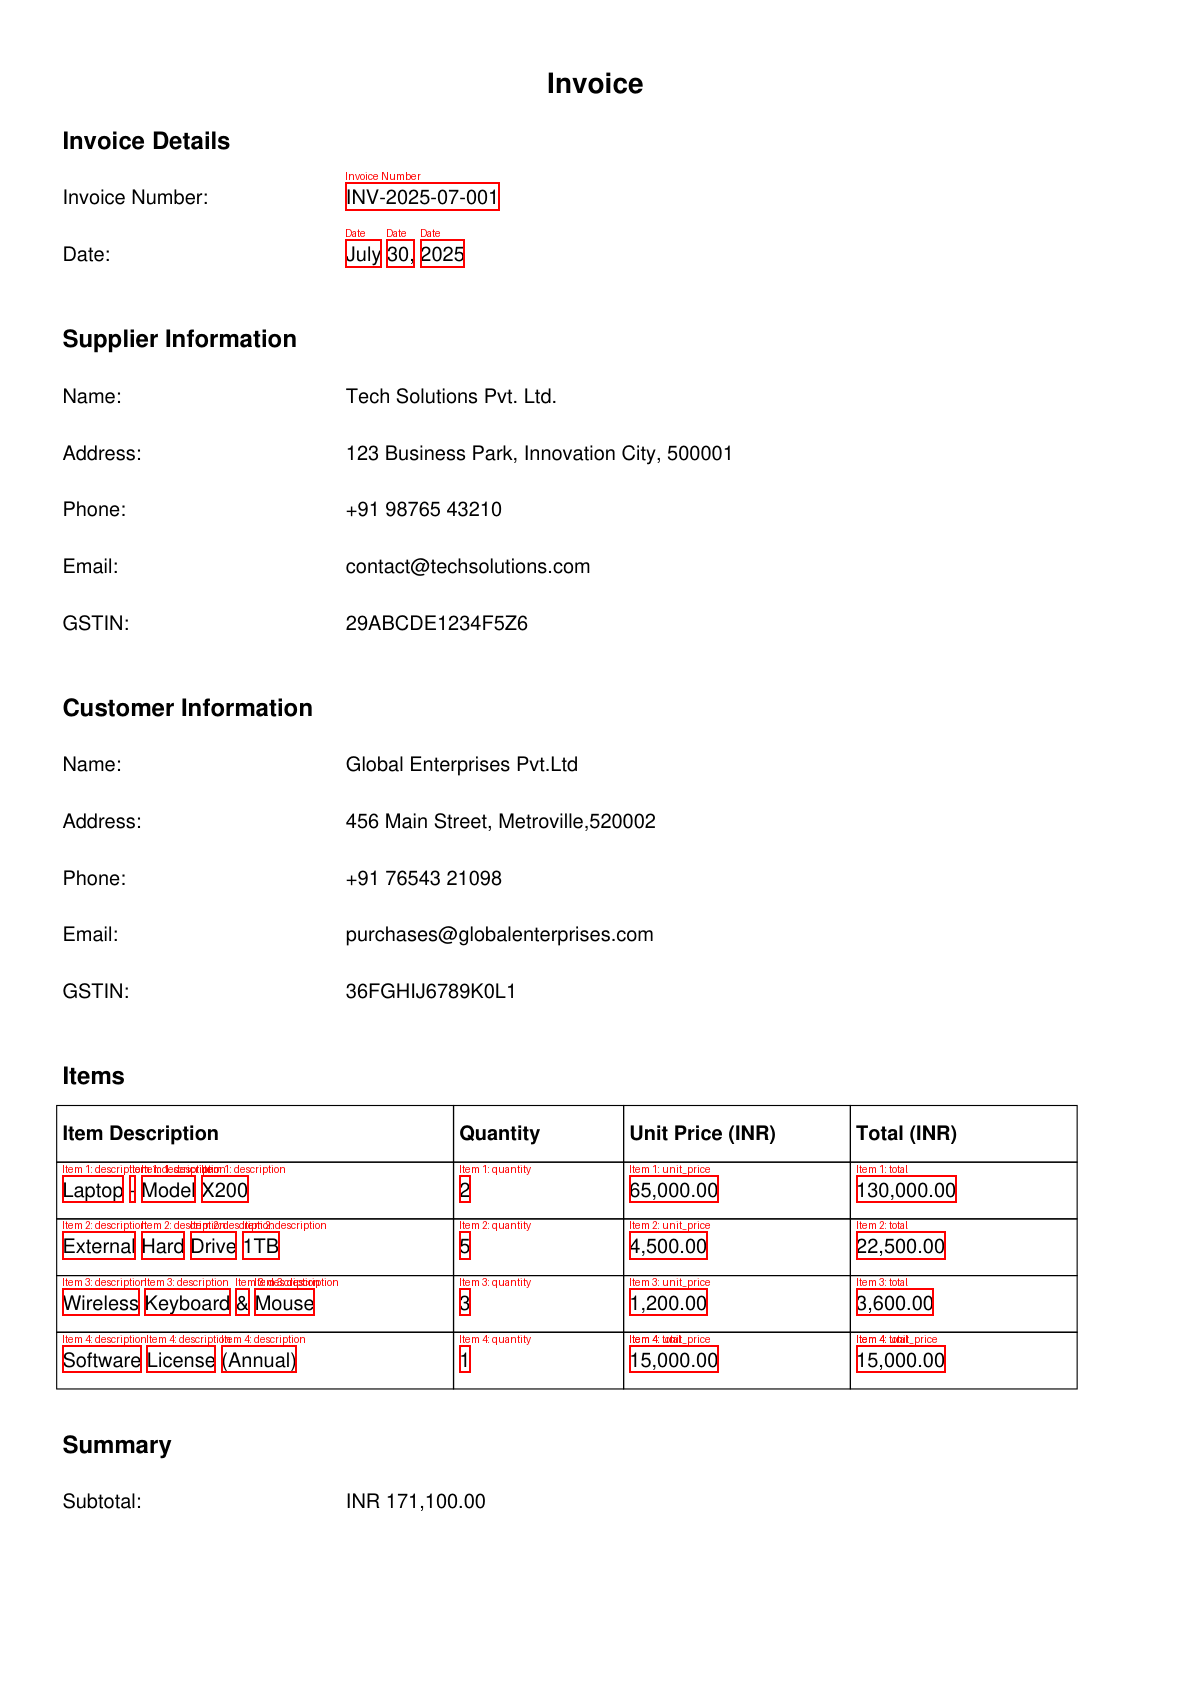

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
# Display & Save
display(img)
img.save("highlighted_invoice.png")
files.download("highlighted_invoice.png")